> To issue any SQL query, use the sql() method on the SparkSession instance, spark,
such as spark.sql("SELECT * FROM myTableName").

### Airline On-Time
a few examples of queries on the **Airline On-Time Performance and Causes of Flight Delays** data set, which contains data on US flights including date, delay, distance, origin, and destination. It’s available as a CSV file with over a million records. Using a schema, we’ll read the data into a DataFrame and register the DataFrame as a temporary view (more on temporary views shortly) so we can query it with SQL.

In [1]:

from pyspark.sql import SparkSession
# Create a SparkSession
spark = (SparkSession
.builder
.appName("SparkSQLExampleApp")
.getOrCreate())

24/05/08 11:33:22 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/05/08 11:33:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/08 11:33:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Path to data set
csv_file = "./learning-spark-v2/flights/departuredelays.csv"

load the data

In [6]:
# In Python
schema = "`date` STRING, `delay` INT, `distance` INT,`origin` STRING, `destination` STRING"
# load data

df = (spark.read.format("csv")
.schema(schema) #.option("inferSchema", "true")
.option("header", "true")
.load(csv_file))

create the view

In [7]:
print(df.printSchema())
df.show(5)

root
 |-- date: string (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)

None
+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 5 rows



In [8]:
df.createOrReplaceTempView("us_delay_flights_tbl")

> • The date column contains a string like 02190925. When converted, this maps to
02-19 09:25 am. <br>
• The delay column gives the delay in minutes between the scheduled and actual
departure times. Early departures show negative numbers. <br>
• The distance column gives the distance in miles from the origin airport to the
destination airport. <br>
• The origin column contains the origin IATA airport code. <br>
• The destination column contains the destination IATA airport code. <br>

Flights where the distance is greater than 1000 miles

In [9]:
spark.sql("""SELECT distance, origin, destination
FROM us_delay_flights_tbl WHERE distance > 1000
ORDER BY distance DESC""").show(10)

+--------+------+-----------+
|distance|origin|destination|
+--------+------+-----------+
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
+--------+------+-----------+
only showing top 10 rows



all flights between San Francisco (SFO) and Chicago
(ORD) with at least a two-hour delay:

In [10]:
spark.sql("""SELECT date, delay, origin, destination
FROM us_delay_flights_tbl
WHERE delay > 120 AND ORIGIN = 'SFO' AND DESTINATION = 'ORD'
ORDER by delay DESC""").show(10)

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02190925| 1638|   SFO|        ORD|
|01031755|  396|   SFO|        ORD|
|01022330|  326|   SFO|        ORD|
|01051205|  320|   SFO|        ORD|
|01190925|  297|   SFO|        ORD|
|02171115|  296|   SFO|        ORD|
|01071040|  279|   SFO|        ORD|
|01051550|  274|   SFO|        ORD|
|03120730|  266|   SFO|        ORD|
|01261104|  258|   SFO|        ORD|
+--------+-----+------+-----------+
only showing top 10 rows



> As an exercise, convert the date column into a readable format and find
the days or months when these delays were most common. Were the delays related to winter months or holidays?

this is how to convert to timeStamp

In [11]:
spark.sql("""SELECT date,
to_timestamp(date, 'MMddHHmm') AS timestamp,
date_format(to_timestamp(date, 'MMddHHmm'), 'MM-dd hh:mm a') AS formatted_timestamp
FROM us_delay_flights_tbl
WHERE delay > 120 AND ORIGIN = 'SFO' AND DESTINATION = 'ORD'
ORDER by delay DESC
""").show(10)

+--------+-------------------+-------------------+
|    date|          timestamp|formatted_timestamp|
+--------+-------------------+-------------------+
|02190925|1970-02-19 09:25:00|     02-19 09:25 AM|
|01031755|1970-01-03 17:55:00|     01-03 05:55 PM|
|01022330|1970-01-02 23:30:00|     01-02 11:30 PM|
|01051205|1970-01-05 12:05:00|     01-05 12:05 PM|
|01190925|1970-01-19 09:25:00|     01-19 09:25 AM|
|02171115|1970-02-17 11:15:00|     02-17 11:15 AM|
|01071040|1970-01-07 10:40:00|     01-07 10:40 AM|
|01051550|1970-01-05 15:50:00|     01-05 03:50 PM|
|03120730|1970-03-12 07:30:00|     03-12 07:30 AM|
|01261104|1970-01-26 11:04:00|     01-26 11:04 AM|
+--------+-------------------+-------------------+
only showing top 10 rows



In [18]:
spark.sql("""SELECT year(to_timestamp(date, 'MMddHHmm')) as YEAR, month(to_timestamp(date, 'MMddHHmm')) AS MONTH,
COUNT(delay) AS TotalDelayMinutes
FROM us_delay_flights_tbl
WHERE delay > 120 AND ORIGIN = 'SFO' AND DESTINATION = 'ORD'
GROUP BY year(to_timestamp(date, 'MMddHHmm')), month(to_timestamp(date, 'MMddHHmm'))
""").show(10)

+----+-----+-----------------+
|YEAR|MONTH|TotalDelayMinutes|
+----+-----+-----------------+
|1970|    1|               22|
|1970|    2|               17|
|1970|    3|               16|
+----+-----+-----------------+



In the following
example, we want to label all US flights, regardless of origin and destination,
with an indication of the delays they experienced: Very Long Delays (> 6 hours),
Long Delays (2–6 hours), etc. We’ll add these human-readable labels in a new column
called Flight_Delays:
Using

In [16]:
query = """
SELECT delay, origin, destination, to_timestamp(date, 'MMddHHmm') AS timestamp,
CASE
    WHEN delay >= 360 THEN 'Very Long Delays'
    WHEN delay >= 120 AND delay < 360 THEN 'Long Delay'
    WHEN delay >= 60 AND delay < 120 THEN 'Short Delay'
    WHEN delay > 0 and delay < 60 THEN 'Tolerable Delays'
    WHEN delay = 0 THEN 'No Delays'
    ELSE 'Early' 
END As Flight_Delay
FROM us_delay_flights_tbl
ORDER BY delay DESC
"""

In [17]:
spark.sql(query).show(20)

+-----+------+-----------+-------------------+----------------+
|delay|origin|destination|          timestamp|    Flight_Delay|
+-----+------+-----------+-------------------+----------------+
| 1642|   TPA|        DFW|1970-03-09 06:15:00|Very Long Delays|
| 1638|   SFO|        ORD|1970-02-19 09:25:00|Very Long Delays|
| 1636|   FLL|        DFW|1970-02-02 12:45:00|Very Long Delays|
| 1592|   RSW|        ORD|1970-03-02 07:00:00|Very Long Delays|
| 1560|   BNA|        DFW|1970-01-18 08:05:00|Very Long Delays|
| 1553|   PDX|        DFW|1970-03-03 12:10:00|Very Long Delays|
| 1543|   CLE|        DFW|1970-03-07 06:45:00|Very Long Delays|
| 1511|   MCO|        ORD|1970-02-21 06:30:00|Very Long Delays|
| 1500|   EGE|        JFK|1970-01-30 09:15:00|Very Long Delays|
| 1496|   ONT|        DFW|1970-01-15 07:15:00|Very Long Delays|
| 1482|   EGE|        DFW|1970-01-30 07:25:00|Very Long Delays|
| 1470|   ELP|        DFW|1970-03-13 07:05:00|Very Long Delays|
| 1461|   AUS|        LAX|1970-02-12 07:

# SQL Tables and Views
> **Tables** hold data. *Associated with each table* in Spark is its relevant **metadata**, which is
information about the table and its data: the schema, description, table name, database
name, column names, partitions, physical location <br>

## Managed vs Unmanaged Tables
* **managed table**: Spark manages both the metadata and the data in the file store. 
* **unmanaged table**, Spark only manages the metadata, while you manage the data yourself in an external data source such as Cassandra.




## Creating SQL Databases and Tables
By default, Spark creates tables under the default
database. **To create your own database name**, you can issue a SQL command from
your Spark application or notebook

In [ ]:
# Python
spark.sql("CREATE DATABASE learn_spark_db")
spark.sql("USE learn_spark_db")

> From this point onwards, all tables that you create will be created in this database

In [ ]:
# CREATE TABLE 
spark.sql("CREATE TABLE managed_us_delay_flights_tbl (date STRING, delay INT, distance INT, origin STRING, destination STRING)")

In [ ]:
# INSERT INTO
spark.sql("INSERT INTO TABLE managed_us_delay_flights_tbl SELECT * FROM csv.`/databricks-datasets/learning-spark-v2/flights/departuredelays.csv`")


#### You can do the same thing using the DataFrame API like this:
---

In [ ]:
# Path to our US flight delays CSV file
csv_file = "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
# Schema as defined in the preceding example
schema="date STRING, delay INT, distance INT, origin STRING, destination STRING"
flights_df = spark.read.csv(csv_file, schema=schema)
#flights_df.write.saveAsTable("managed_us_delay_flights_tbl")

---

#### Unmanaged Table

In [ ]:
spark.sql("""CREATE TABLE us_delay_flights_tbl(date STRING, delay INT,
distance INT, origin STRING, destination STRING)
USING csv OPTIONS (PATH '/databricks-datasets/learning-spark-v2/flights/departuredelays.csv')""")

## Table Views

> oposite to tables, views are temporary: they disappear after your Spark application terminates. <br>
> Views can be global (visible across all SparkSessions on a given cluster) or session-scoped (visible only to a single SparkSession)

**first select the data**

In [ ]:
# In Python
df_sfo = spark.sql("SELECT date, delay, origin, destination FROM us_delay_flights_tbl WHERE origin = 'SFO'")
df_jfk = spark.sql("SELECT date, delay, origin, destination FROM us_delay_flights_tbl WHERE origin = 'JFK'")

**put it on a view**

In [ ]:
# Create a temporary and global temporary view
df_sfo.createOrReplaceGlobalTempView("us_origin_airport_SFO_global_tmp_view")
df_jfk.createOrReplaceTempView("us_origin_airport_JFK_tmp_view") # use _tmp_view to identify views

> <mark>RECALL:</mark> tables persist after your Spark application
terminates, but views disappear

In [ ]:
# read view like a table

# In Scala/Python
spark.read.table("us_origin_airport_JFK_tmp_view")
# Or
spark.sql("SELECT * FROM us_origin_airport_JFK_tmp_view")

**drop views**

In [ ]:

# In Scala/Python
spark.catalog.dropGlobalTempView("us_origin_airport_SFO_global_tmp_view")
spark.catalog.dropTempView("us_origin_airport_JFK_tmp_view")

if you need to read a global view, you need to add the prefix **global_temp.**<your_view_name>
Example
> SELECT * FROM <mark>global_temp.</mark>us_origin_airport_SFO_global_tmp_view


### Viewing the Metadata


In [ ]:
# In Scala/Python
spark.catalog.listDatabases()
spark.catalog.listTables()
spark.catalog.listColumns("us_delay_flights_tbl")

### Caching Tables

In [ ]:
# SQL
query = '''CACHE [LAZY] TABLE <table-name>
UNCACHE TABLE <table-name>'''

### Reading Tables into DataFrames
you can simply use SQL to query the table and assign the returned result to a
DataFrame:

In [ ]:
# way 1
us_flights_df = spark.sql("SELECT * FROM us_delay_flights_tbl")
# way 2
us_flights_df2 = spark.table("us_delay_flights_tbl")

# Data Sources for DataFrames and SQL Tables

## DataFrameReader
DataFrameReader is the core construct for reading data from a data source into a
DataFrame. It has a defined format and a recommended pattern for usage:
> DataFrameReader.format(args).option("key", "value").schema(args).load()

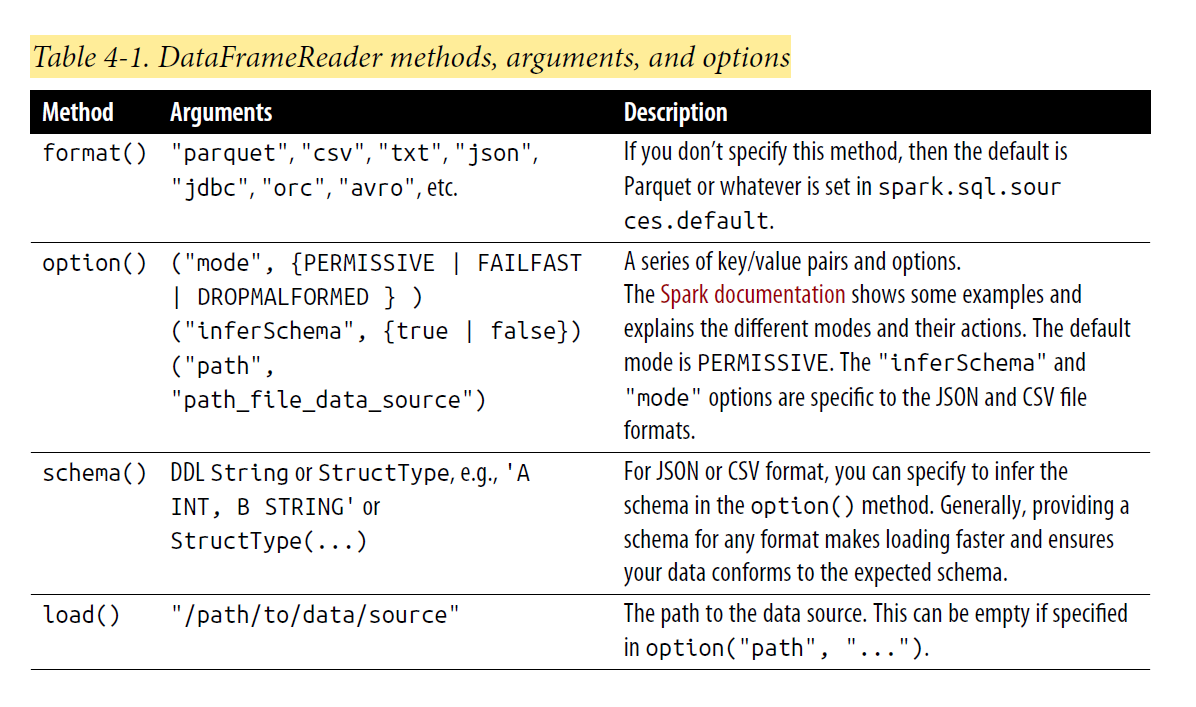

## DataFrameWriter
DataFrameWriter does the reverse of its counterpart: it saves or writes data to a specified
built-in data source.

In [ ]:
#few recommended usage patterns:
DataFrameWriter.format(args)
.option(args)
.bucketBy(args)
.partitionBy(args)
.save(path)

DataFrameWriter.format(args).option(args).sortBy(args).saveAsTable(table)

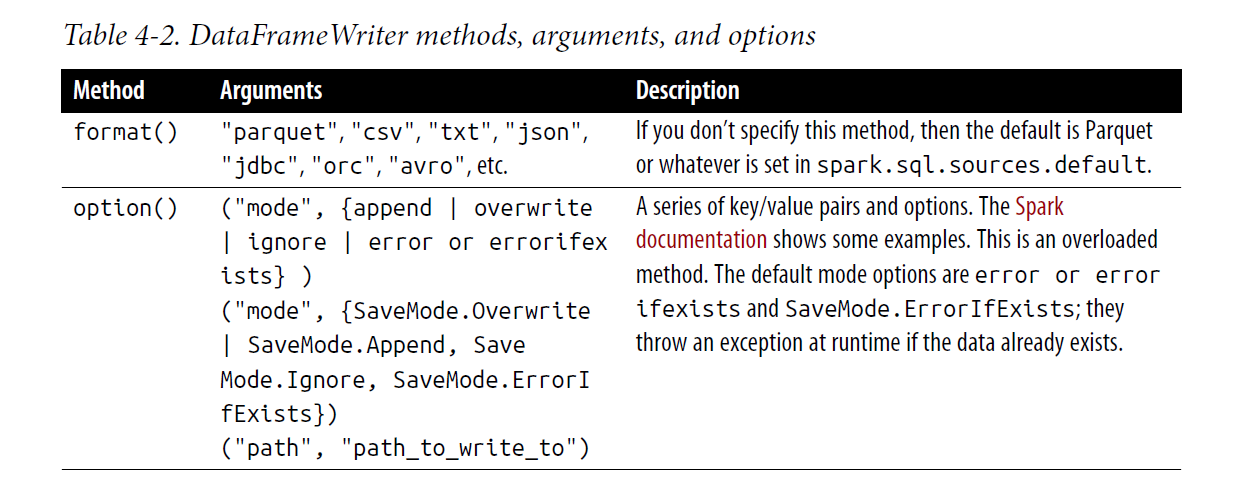

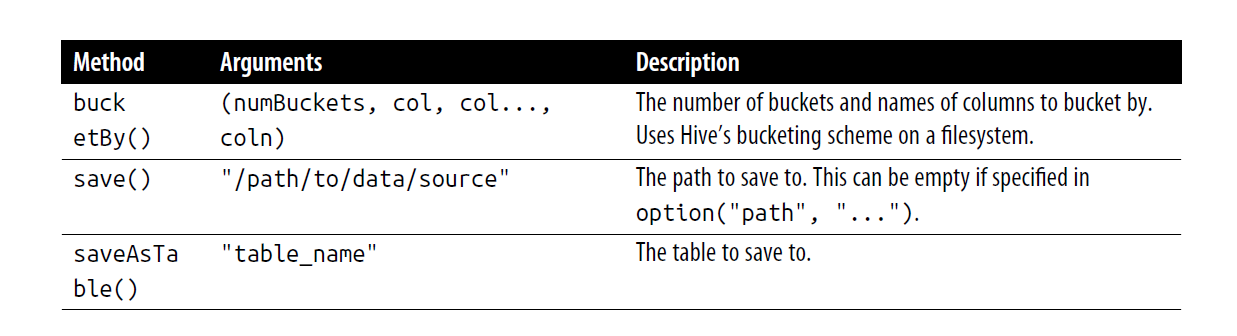

## Parquet

In [ ]:
# In Python READ
file = """/databricks-datasets/learning-spark-v2/flights/summary-data/parquet/
2010-summary.parquet/"""
df = spark.read.format("parquet").load(file)

In [ ]:
# WRITE
# In Python
(df.write.format("parquet")
.mode("overwrite")
.option("compression", "snappy")
.save("/tmp/data/parquet/df_parquet"))

# User-Defined Functions
While Apache Spark has a plethora of built-in functions, the flexibility of Spark
allows for data engineers and data scientists to define their own functions too. These
are known as user-defined functions (UDFs).

In [ ]:
# In Python
from pyspark.sql.types import LongType

# Create cubed function
def cubed(s):
  return s * s * s

# Register UDF
spark.udf.register("cubed", cubed, LongType())

# Generate temporary view
spark.range(1, 9).createOrReplaceTempView("udf_test")

#Use it
spark.sql("SELECT id, cubed(id) AS id_cubed FROM udf_test").show()

**Evaluation order and null checking in Spark SQL**
> in the WHERE clauses clause1 AND clause2 AND .....
> there is no guarantee that clause1 will be executed first

In [ ]:
spark.sql("SELECT s FROM test1 WHERE s IS NOT NULL AND strlen(s) > 1")
# Here the s is NOT NULL clause may not be executed prior to the strlen(s) > 1 clause

Therefore, to perform proper null checking, it is recommended that you do the
following:
1. Make the UDF itself null-aware and do null checking inside the UDF.
2. Use IF or CASE WHEN expressions to do the null check and invoke the UDF in a
conditional branch.